In [1]:
import os
import scipy.io as sio
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

In [2]:
def cart2pol_3D(x,y,z):
    r = np.sqrt(x**2+y**2+z**2)
    azi = -np.arctan2(y,x)
    ele = np.arcsin(z/r)
    return np.rad2deg(azi),np.rad2deg(ele),r

def pol2cart_3D(azi_deg, ele_deg, rho):
    x = rho * np.cos(np.deg2rad(ele_deg)) * np.cos(np.deg2rad(-azi_deg))
    y = rho * np.cos(np.deg2rad(ele_deg)) * np.sin(np.deg2rad(-azi_deg)) 
    z = rho * np.sin(np.deg2rad(ele_deg)) 
    return x, y, z

In [3]:
def JH_KvD(XYUV):
    T0 = R0 = [1,0,0]
    it_num = 20  # number of iteration
    nXYUV = np.shape(XYUV)[0]
    d_cart2D = XYUV[:,0:2]
    d_cart3D = pol2cart_3D(d_cart2D[:,0],d_cart2D[:,1],1)
    d_cart3D = np.transpose(d_cart3D)
    p_cart2D = XYUV[:,2:4] 
    p_cart3D = np.zeros_like(d_cart3D)
    for i in range(nXYUV):
        d = d_cart3D[i]
        u_hat = np.cross(d,[0,0,1]) / np.linalg.norm(np.cross(d,[0,0,1]))
        v_hat = np.cross(u_hat,d) / np.linalg.norm(np.cross(u_hat,d))
        p_cart3D[i,:] = u_hat * p_cart2D[i,0] + v_hat * p_cart2D[i,1]
    R_arr = T_arr = np.zeros(shape=(0,3))
    for iteration in range(it_num):  # <<<============== start of iteration
        R_arr = np.append(R_arr,[R0],axis=0)
        T_arr = np.append(T_arr,[T0],axis=0)
        d_num = p_sum = d_sum = pxd_sum = delta_sum = 0
        for i in range(nXYUV):
            d = d_cart3D[i,:]
            p = p_cart3D[i,:]
            d_num += 1
            p_sum += p
            d_sum += d
            pxd_sum += np.cross(p,d)
            delta_sum += (np.eye(3) - np.outer(d,d))
        p_mean = p_sum / d_num
        d_mean = d_sum / d_num
        pxd_mean = pxd_sum / d_num
        delta_mean = np.linalg.inv(delta_sum / d_num)  #<<< 3x3 matrix
        R1=np.dot(delta_mean, pxd_mean + np.cross(T0,d_mean))
        T1=np.dot(delta_mean, - p_mean - np.cross(R0,d_mean))
        R0=R1
        T0=T1
    R_arr_pol = cart2pol_3D(R_arr[:,0],R_arr[:,1],R_arr[:,2])
    T_arr_pol = cart2pol_3D(T_arr[:,0],T_arr[:,1],T_arr[:,2])
    R_arr_pol = np.transpose(R_arr_pol)
    T_arr_pol = np.transpose(T_arr_pol)
    return R_arr_pol[len(R_arr_pol)-1], T_arr_pol[len(T_arr_pol)-1]

In [4]:
def JH_Kabsch(XYUV):

    XYUV_raw=np.zeros(shape=(0,3))
    XYUV_new=np.zeros(shape=(0,3))

    for i in range(len(XYUV)):
        vec=pol2cart_3D(XYUV[i,0],XYUV[i,1],1)
        XYUV_raw=np.append(XYUV_raw, [vec], axis=0)

        vec_new=pol2cart_3D(XYUV[i,0]+XYUV[i,2],XYUV[i,1]+XYUV[i,3],1)
        XYUV_new=np.append(XYUV_new, [vec_new], axis=0)

    mestimated_rotation , _ = R.align_vectors(XYUV_raw,XYUV_new)

    mx = mestimated_rotation.as_rotvec()
    rotvec=cart2pol_3D(mx[0], mx[1], mx[2])
    azi_rot=rotvec[0]
    ele_rot=rotvec[1]

    return [azi_rot,ele_rot]

In [8]:
def get_motion_axes(filelist, quiver_scale=5):

    XYUV_arr=np.zeros(shape=(0,84,4))
    for n in range(len(filelist)):
        fn=filelist[n]
        # print(fn)

        file = file_path + '/' + fn 
        XYUV = sio.loadmat(file)['XYUV']
        idx=np.lexsort((XYUV[:,1],XYUV[:,0]),axis=0)
        XYUV_sort=XYUV[idx]
        XYUV_arr=np.append(XYUV_arr, [XYUV_sort],axis=0)

    XYUV_mean=np.mean(XYUV_arr,axis=0)
    for i in range(len(XYUV_mean)):
        if XYUV_mean[i,0]==-180:
            XYUV_mean=np.append(XYUV_mean,[[180,XYUV_mean[i,1],XYUV_mean[i,2],XYUV_mean[i,3]]],axis=0)

    XYUV_mean[:,2] = -XYUV_mean[:,2]
    XYUV_mean[:,3] = -XYUV_mean[:,3]
    X=XYUV_mean[:,0]
    Y=XYUV_mean[:,1]
    U=XYUV_mean[:,2]
    V=XYUV_mean[:,3]

    iX,iY = np.meshgrid(np.arange(-180,181,15),np.arange(-75,76,15))
    # iU = np.zeros_like(iX,dtype=np.float64)
    # iV = np.zeros_like(iY,dtype=np.float64)
    iU = interpolate.griddata((X,Y),U,(iX,iY),method='linear')
    iV = interpolate.griddata((X,Y),V,(iX,iY),method='linear')

    fig=plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')
    plt.quiver(iX,iY,iU,iV,scale=quiver_scale,units='xy',color='grey',width=1,headwidth=2,headlength=4) 
    plt.quiver(X,Y,U,V,scale=quiver_scale,units='xy',color='k',width=1,headwidth=2,headlength=4)   
    ax=plt.gca()
    plt.xlabel("Azimuth (deg)",fontsize=24)
    plt.ylabel("Elevation (deg)",fontsize=24)
    Az_ticks = np.arange(-180, 181, 30)  
    ax.set_xticks(Az_ticks) 
    Az_minor_ticks = np.arange(-180, 181, 15)  
    ax.set_xticks(Az_minor_ticks, minor=1)
    El_ticks = np.arange(-75, 76, 30)  
    ax.set_yticks(El_ticks) 
    El_minor_ticks = np.arange(-75, 76, 15)  
    ax.set_yticks(El_minor_ticks, minor=1)  
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    ax.set_aspect(1)


    KvD_R,KvD_T=JH_KvD(XYUV_mean)#;print('KvD_R=',KvD_R,'KvD_T=',KvD_T)
    Kabsch_R=JH_Kabsch(XYUV_mean)#;print('Kabsch_R=',Kabsch_R

    print(filelist[0].split('_M_')[0], ', N=', len(filelist))
    print('Kabsch_R=',np.round(Kabsch_R))
    print('KvD_R=',np.round(KvD_R[0:2]))
    print('KvD_T=',np.round(KvD_T[0:2]))
    

<<< input >>>
[XYUV_th]Clement_Blowfly_2018-08-03_F_c2r1[H1L].mat
 
<<< output >>>
['[XYUV_th]Clement_Blowfly_2018-08-03_F_c2r1[H1L].mat']
[XYUV_th]Clement_Blowfly_2018-08-03_F_c2r1[H1L].mat , N= 1
Kabsch_R= [-32.  73.]
KvD_R= [-41.  79.]
KvD_T= [-129.   17.]


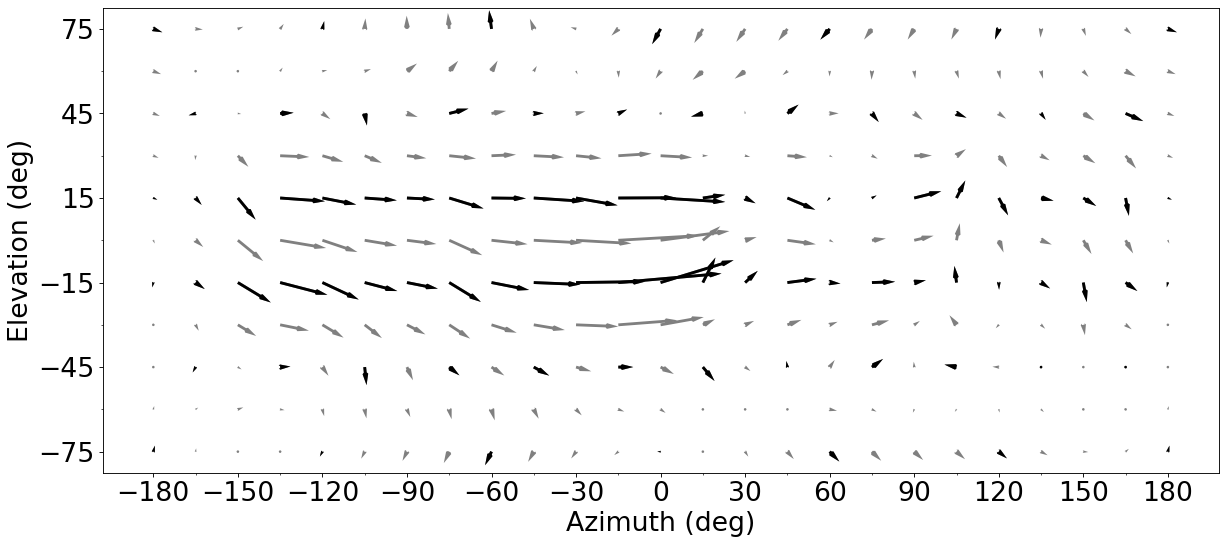

In [10]:
file_path='/Users/nikitazabolotniy/Desktop/FWDmodel/[quiver_th]Clement_Blowfly_2018-08-03_F_c2r1[H1L]'
filelist=[x for x in os.listdir(file_path) if '.mat' in x]

print('<<< input >>>')
print('\n'.join(filelist))
print(' ')
print('<<< output >>>')

quiver_scale = 8
subfilelist=[]
for n in range(len(filelist)):
    # print(filelist[n],filelist[n].split('_M_')[0])
    # print(subfilelist)

    if subfilelist==[] :
        subfilelist.append(filelist[n])

    elif ( filelist[n].split('_M_')[0] == subfilelist[0].split('_M_')[0]):
        subfilelist.append(filelist[n])

    elif ( filelist[n].split('_M_')[0] != subfilelist[0].split('_M_')[0]):
        print(subfilelist)  #<<< debug
        get_motion_axes(filelist=subfilelist, quiver_scale=quiver_scale)
        subfilelist=[]
        subfilelist.append(filelist[n])

    if n == len(filelist)-1:
        print(subfilelist)  #<<< debug
        get_motion_axes(filelist=subfilelist, quiver_scale=quiver_scale)

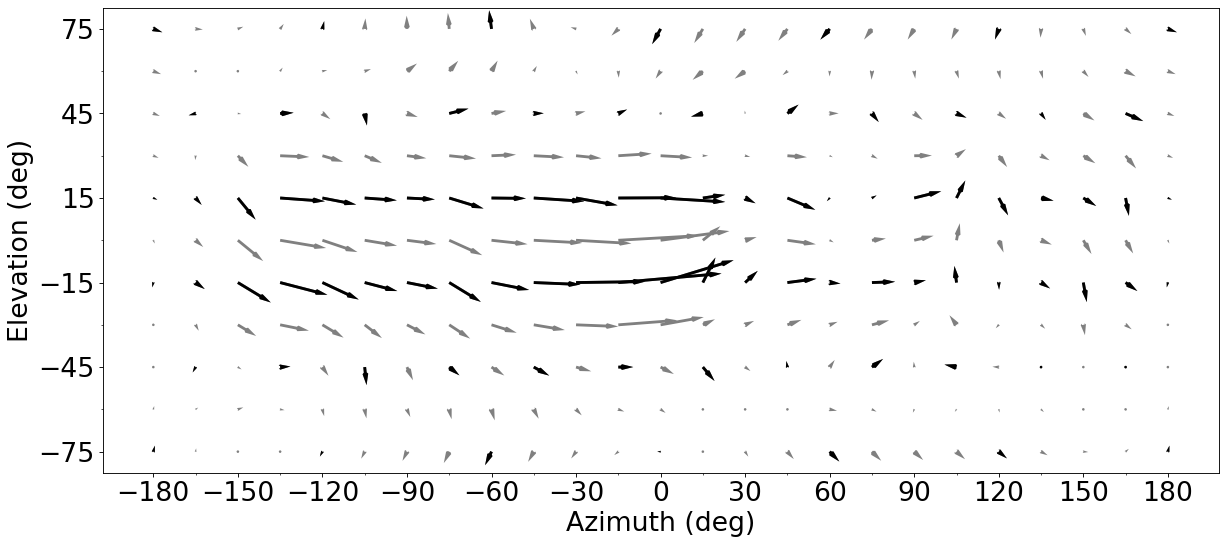

In [75]:
XYUV_arr=np.zeros(shape=(0,84,4))
filelist = subfilelist
quiver_scale = 8
for n in range(len(filelist)):
    fn=filelist[n]
    # print(fn)

    file = file_path + '/' + fn 
    XYUV = sio.loadmat(file)['XYUV']
    idx=np.lexsort((XYUV[:,1],XYUV[:,0]),axis=0)
    XYUV_sort=XYUV[idx]
    XYUV_arr=np.append(XYUV_arr, [XYUV_sort],axis=0)

XYUV_mean=np.mean(XYUV_arr,axis=0)
for i in range(len(XYUV_mean)):
    if XYUV_mean[i,0]==-180:
        XYUV_mean=np.append(XYUV_mean,[[180,XYUV_mean[i,1],XYUV_mean[i,2],XYUV_mean[i,3]]],axis=0)

XYUV_mean[:,2] = -XYUV_mean[:,2]
XYUV_mean[:,3] = -XYUV_mean[:,3]
X=XYUV_mean[:,0]
Y=XYUV_mean[:,1]
U=XYUV_mean[:,2]
V=XYUV_mean[:,3]

iX,iY = np.meshgrid(np.arange(-180,181,15),np.arange(-75,76,15))
# iU = np.zeros_like(iX,dtype=np.float64)
# iV = np.zeros_like(iY,dtype=np.float64)
iU = interpolate.griddata((X,Y),U,(iX,iY),method='linear')
iV = interpolate.griddata((X,Y),V,(iX,iY),method='linear')

fig=plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')
plt.quiver(iX,iY,iU,iV,scale=quiver_scale,units='xy',color='grey',width=1,headwidth=2,headlength=4) 
plt.quiver(X,Y,U,V,scale=quiver_scale,units='xy',color='k',width=1,headwidth=2,headlength=4)   
ax=plt.gca()
plt.xlabel("Azimuth (deg)",fontsize=24)
plt.ylabel("Elevation (deg)",fontsize=24)
Az_ticks = np.arange(-180, 181, 30)  
ax.set_xticks(Az_ticks) 
Az_minor_ticks = np.arange(-180, 181, 15)  
ax.set_xticks(Az_minor_ticks, minor=1)
El_ticks = np.arange(-75, 76, 30)  
ax.set_yticks(El_ticks) 
El_minor_ticks = np.arange(-75, 76, 15)  
ax.set_yticks(El_minor_ticks, minor=1)  
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.set_aspect(1)

In [108]:
XYUV_mean_flip = XYUV_mean.copy()
data_pts = XYUV_mean.shape[0]
run = True
row_n = 0
while(run):
    azi_val = XYUV_mean_flip[row_n,0]
    n_matches = np.sum(azi_val == XYUV_mean_flip[row_n:row_n+4,0])
    if n_matches == 4:
        XYUV_mean_flip_seg = XYUV_mean_flip[row_n:row_n + 4, :]
        XYUV_mean_seg = XYUV_mean[data_pts - row_n - 4:data_pts - row_n, :]
        XYUV_mean_flip_seg[:,2] = -XYUV_mean_seg[:,2]
        XYUV_mean_flip_seg[:,3] = XYUV_mean_seg[:,3]
        XYUV_mean_flip[row_n:row_n+4,:] = XYUV_mean_flip_seg
        row_n += 4
    else:
        XYUV_mean_flip_seg = XYUV_mean_flip[row_n:row_n + 2, :]
        XYUV_mean_seg = XYUV_mean[data_pts - row_n - 2:data_pts - row_n, :]
        XYUV_mean_flip_seg[:,2] = -XYUV_mean_seg[:,2]
        XYUV_mean_flip_seg[:,3] = XYUV_mean_seg[:,3]
        XYUV_mean_flip[row_n:row_n + 2,:] = XYUV_mean_flip_seg
        row_n += 2
    if XYUV_mean_flip_seg[0,0] == 180:
        run = False

In [111]:
JH_KvD(XYUV_mean)

(array([-40.80474766,  79.33905304,  65.12999447]),
 array([-129.27060141,   17.0351516 ,   33.90946682]))

In [110]:
JH_KvD(XYUV_mean_flip)

(array([-139.19525234,  -79.33905304,   65.12999447]),
 array([129.27060141,  17.0351516 ,  33.90946682]))

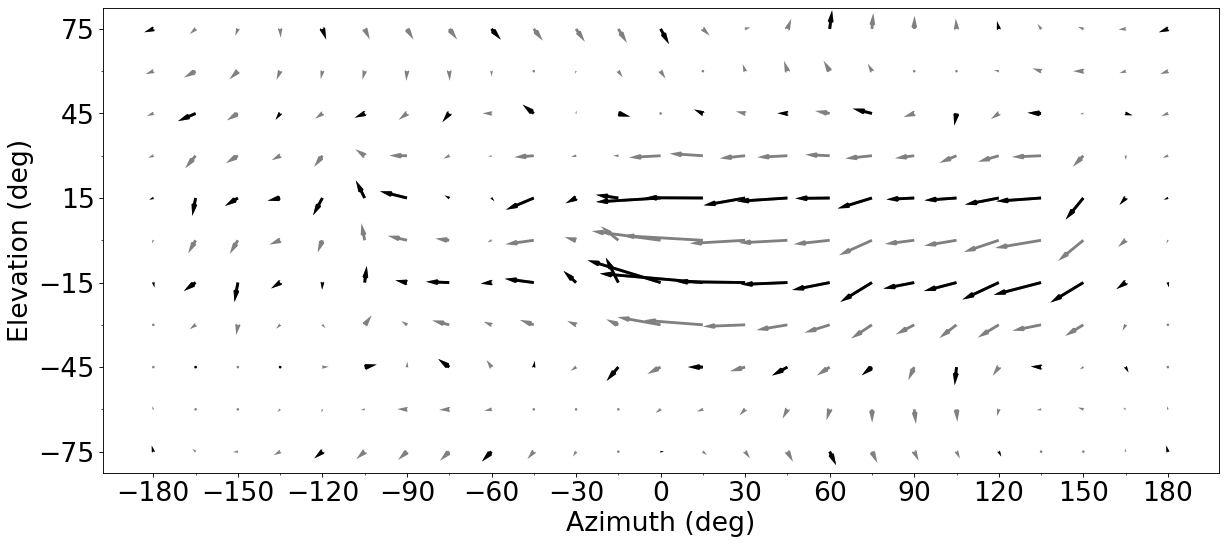

In [109]:
X=XYUV_mean_flip[:,0]
Y=XYUV_mean_flip[:,1]
U=XYUV_mean_flip[:,2]
V=XYUV_mean_flip[:,3]

iX,iY = np.meshgrid(np.arange(-180,181,15),np.arange(-75,76,15))
# iU = np.zeros_like(iX,dtype=np.float64)
# iV = np.zeros_like(iY,dtype=np.float64)
iU = interpolate.griddata((X,Y),U,(iX,iY),method='linear')
iV = interpolate.griddata((X,Y),V,(iX,iY),method='linear')

fig=plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')
plt.quiver(iX,iY,iU,iV,scale=quiver_scale,units='xy',color='grey',width=1,headwidth=2,headlength=4) 
plt.quiver(X,Y,U,V,scale=quiver_scale,units='xy',color='k',width=1,headwidth=2,headlength=4)   
ax=plt.gca()
plt.xlabel("Azimuth (deg)",fontsize=24)
plt.ylabel("Elevation (deg)",fontsize=24)
Az_ticks = np.arange(-180, 181, 30)  
ax.set_xticks(Az_ticks) 
Az_minor_ticks = np.arange(-180, 181, 15)  
ax.set_xticks(Az_minor_ticks, minor=1)
El_ticks = np.arange(-75, 76, 30)  
ax.set_yticks(El_ticks) 
El_minor_ticks = np.arange(-75, 76, 15)  
ax.set_yticks(El_minor_ticks, minor=1)  
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.set_aspect(1)

In [7]:
subfilelist

['[XYUV_th]Clement_Blowfly_2018-08-03_F_c2r1[H1L].mat']

In [68]:
max_len = max(np.linalg.norm(XYUV_mean_M[:,[2,3]], axis=1))

In [91]:
XYUV_33_M = XYUV_mean_M[np.linalg.norm(XYUV_mean_M[:,[2,3]], axis=1) > max_len * 0.25]
XYUV_33_Y = XYUV_mean_Y[np.linalg.norm(XYUV_mean_Y[:,[2,3]], axis=1) > max_len * 0.25]

In [92]:
JH_KvD(XYUV_33_M)

(array([122.35478981,  10.21365306,  15.37331093]),
 array([140.57644058,  65.56402647,   9.33810821]))

In [93]:
JH_KvD(XYUV_33_Y)

(array([137.63213624,  -0.8738372 ,  17.42747814]),
 array([154.67083626,  84.43646412,   7.05697012]))

In [53]:
# XYUV_mean_M[XYUV_mean_M[:,0] <= -45] = XYUV_mean_Y[XYUV_mean_Y[:,0] <= -45]
XYUV_mean_Y[XYUV_mean_Y[:,0] <= -45] = XYUV_mean_M[XYUV_mean_M[:,0] <= -45]

In [160]:
XYUV_mean_Y[XYUV_mean_Y[:,0] <= 30] = XYUV_mean_M[XYUV_mean_M[:,0] <= 30]
XYUV_mean_Y[XYUV_mean_Y[:,0] <= 15] = XYUV_mean_M[XYUV_mean_M[:,0] <= 15]

In [163]:
neg_idx = XYUV_mean_Y[XYUV_mean_Y[:,0] < -15].shape[0]
pos_idx = XYUV_mean_Y[XYUV_mean_Y[:,0] > 75].shape[0]
XYUV_mean_Y[:neg_idx,[2,3]] = np.zeros((neg_idx,2))
XYUV_mean_Y[-pos_idx:,[2,3]] = np.zeros((pos_idx,2))

neg_idx = XYUV_mean_M[XYUV_mean_M[:,0] < -15].shape[0]
pos_idx = XYUV_mean_M[XYUV_mean_M[:,0] > 75].shape[0]
XYUV_mean_M[:neg_idx,[2,3]] = np.zeros((neg_idx,2))
XYUV_mean_M[-pos_idx:,[2,3]] = np.zeros((pos_idx,2))

In [164]:
JH_KvD(XYUV_mean_Y)

(array([126.21219971,  -2.11600853,   7.99716339]),
 array([-164.50304349,   78.77125895,    7.06484362]))

In [165]:
JH_KvD(XYUV_mean_M)

(array([121.12375631,  -2.10579915,   6.7992821 ]),
 array([-167.32384244,   78.46621412,    6.06522222]))

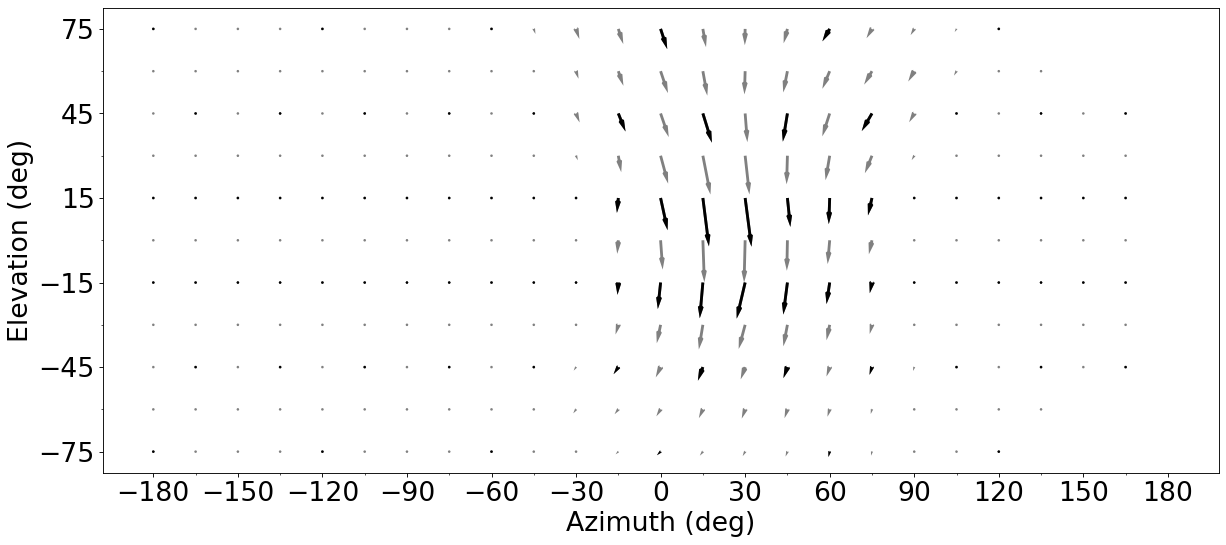

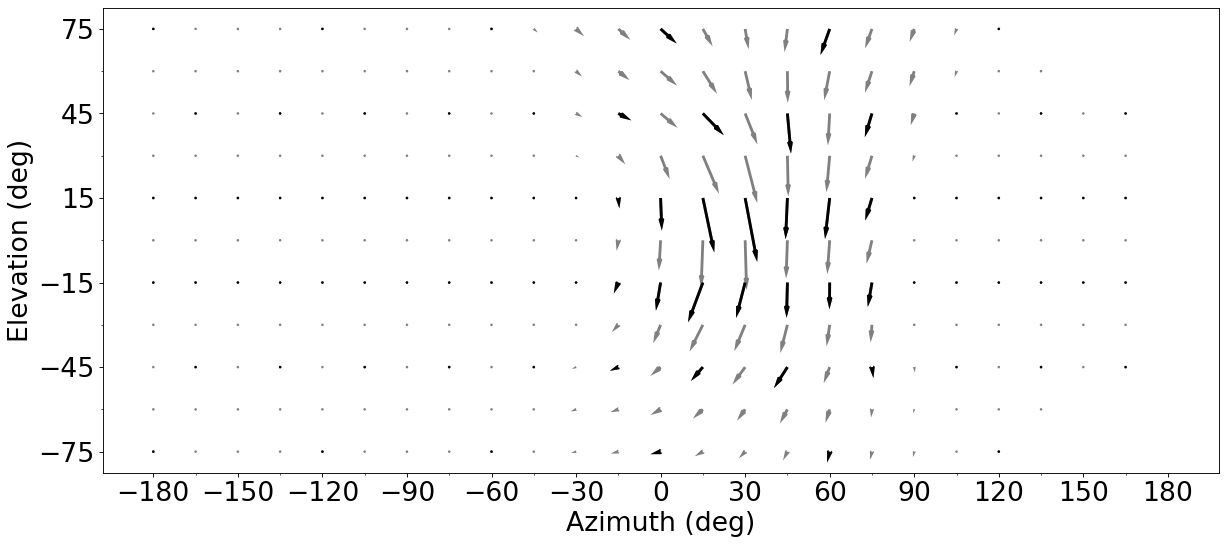

In [154]:
quiver_scale = 2

XYUV_mean = XYUV_mean_M
# XYUV_mean = XYUV_33_M

X=XYUV_mean[:,0]
Y=XYUV_mean[:,1]
U=XYUV_mean[:,2]
V=XYUV_mean[:,3]

iX,iY = np.meshgrid(np.arange(-180,181,15),np.arange(-75,76,15))
# iU = np.zeros_like(iX,dtype=np.float64)
# iV = np.zeros_like(iY,dtype=np.float64)
iU = interpolate.griddata((X,Y),U,(iX,iY),method='linear')
iV = interpolate.griddata((X,Y),V,(iX,iY),method='linear')

fig=plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')
plt.quiver(iX,iY,iU,iV,scale=quiver_scale,units='xy',color='grey',width=1,headwidth=2,headlength=4) 
plt.quiver(X,Y,U,V,scale=quiver_scale,units='xy',color='k',width=1,headwidth=2,headlength=4)   
ax=plt.gca()
plt.xlabel("Azimuth (deg)",fontsize=24)
plt.ylabel("Elevation (deg)",fontsize=24)
Az_ticks = np.arange(-180, 181, 30)  
ax.set_xticks(Az_ticks) 
Az_minor_ticks = np.arange(-180, 181, 15)  
ax.set_xticks(Az_minor_ticks, minor=1)
El_ticks = np.arange(-75, 76, 30)  
ax.set_yticks(El_ticks) 
El_minor_ticks = np.arange(-75, 76, 15)  
ax.set_yticks(El_minor_ticks, minor=1)  
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.set_aspect(1)

XYUV_mean = XYUV_mean_Y
# XYUV_mean = XYUV_33_Y

X=XYUV_mean[:,0]
Y=XYUV_mean[:,1]
U=XYUV_mean[:,2]
V=XYUV_mean[:,3]

iX,iY = np.meshgrid(np.arange(-180,181,15),np.arange(-75,76,15))
# iU = np.zeros_like(iX,dtype=np.float64)
# iV = np.zeros_like(iY,dtype=np.float64)
iU = interpolate.griddata((X,Y),U,(iX,iY),method='linear')
iV = interpolate.griddata((X,Y),V,(iX,iY),method='linear')

fig=plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')
plt.quiver(iX,iY,iU,iV,scale=quiver_scale,units='xy',color='grey',width=1,headwidth=2,headlength=4) 
plt.quiver(X,Y,U,V,scale=quiver_scale,units='xy',color='k',width=1,headwidth=2,headlength=4)   
ax=plt.gca()
plt.xlabel("Azimuth (deg)",fontsize=24)
plt.ylabel("Elevation (deg)",fontsize=24)
Az_ticks = np.arange(-180, 181, 30)  
ax.set_xticks(Az_ticks) 
Az_minor_ticks = np.arange(-180, 181, 15)  
ax.set_xticks(Az_minor_ticks, minor=1)
El_ticks = np.arange(-75, 76, 30)  
ax.set_yticks(El_ticks) 
El_minor_ticks = np.arange(-75, 76, 15)  
ax.set_yticks(El_minor_ticks, minor=1)  
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.set_aspect(1)